In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import pandas as pd
from sklearn.mixture import GaussianMixture
import os


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-06-19 15:17:03.115457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 15:17:03.669091: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64::/home/joel/anaconda3/lib/
2023-06-19 15:17:03.669550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/

In [2]:
df = []

for i in tqdm(glob('/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/general/results/*')):
    
    if '_0.npy' not in i:
        continue
    
    v = np.load(i)
    j = i[:-4]
    for w in range(len(v)):
        df.append(np.concatenate((j.split('/')[-1].split('_'),v[w])))

col = ['architecture','loss','num_classes','degree','latent_size','type','known_variance','static_gamma','coco','chance']
        
#columns = ['architecture','loss','num_classes','degree','factor','type','chance','variance','psnr','psnr std','ssim','ssim std']
columns = np.concatenate((col,['variance','house','peppers','barbara','boats']))
df = pd.DataFrame(df,columns=columns)
df = df[(df.house != 'nan')&(df.peppers!='nan')&(df.barbara!='nan')&(df.boats!='nan')]

df.house = pd.to_numeric(df.house)
df.peppers = pd.to_numeric(df.peppers)
df.barbara = pd.to_numeric(df.barbara)
df.boats = pd.to_numeric(df.boats)
df.variance = pd.to_numeric(df.variance)
df.num_classes = pd.to_numeric(df.num_classes)
df.degree = pd.to_numeric(df.degree)
df.latent_size = pd.to_numeric(df.latent_size)
df.known_variance = pd.to_numeric(df.known_variance)
df.static_gamma = pd.to_numeric(df.static_gamma)
df.coco = pd.to_numeric(df.coco)

df = df[(df.house >0)&(df.peppers>0)&(df.barbara>0)&(df.boats>0)]



100%|███████████████████████████████████| 17694/17694 [00:09<00:00, 1857.97it/s]


In [3]:
df.to_csv('./vsFoE.csv')

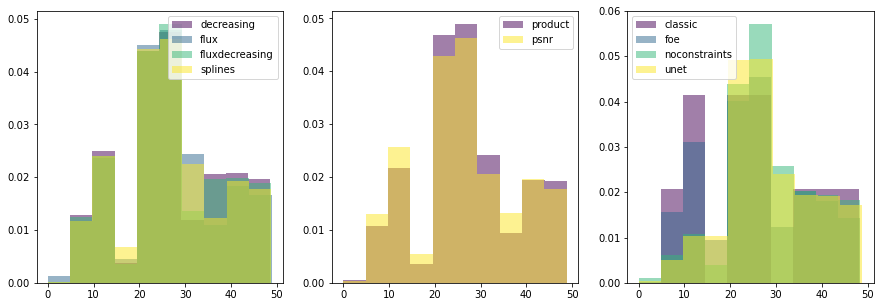

In [4]:
arch = np.unique(df.architecture)
loss = np.unique(df.loss)
types = np.unique(df.type)

imgs = ['house','peppers','barbara','boats']

plt.figure(figsize=(15,5))
plt.subplot(131)
colors = cm.viridis(np.linspace(0,1,len(arch)))
for j,i in enumerate(arch):
    dg = df[df.architecture == i]
    data = dg[imgs].values.flatten()
    plt.hist(data,color=colors[j],range=(0,np.amax(data)),alpha=0.5,label=i,density=True)

plt.legend()
    
plt.subplot(132)
colors = cm.viridis(np.linspace(0,1,len(loss)))
for j,i in enumerate(loss):
    dg = df[df.loss == i]
    data = dg[imgs].values.flatten()
    plt.hist(data,color=colors[j],range=(0,np.amax(data)),alpha=0.5,label=i,density=True)
    
plt.legend()

plt.subplot(133)
colors = cm.viridis(np.linspace(0,1,len(types)))
for j,i in enumerate(types):
    dg = df[df.type == i]
    data = dg[imgs].values.flatten()
    plt.hist(data,color=colors[j],range=(0,np.amax(data)),alpha=0.5,label=i,density=True)
    
plt.legend()
plt.show()

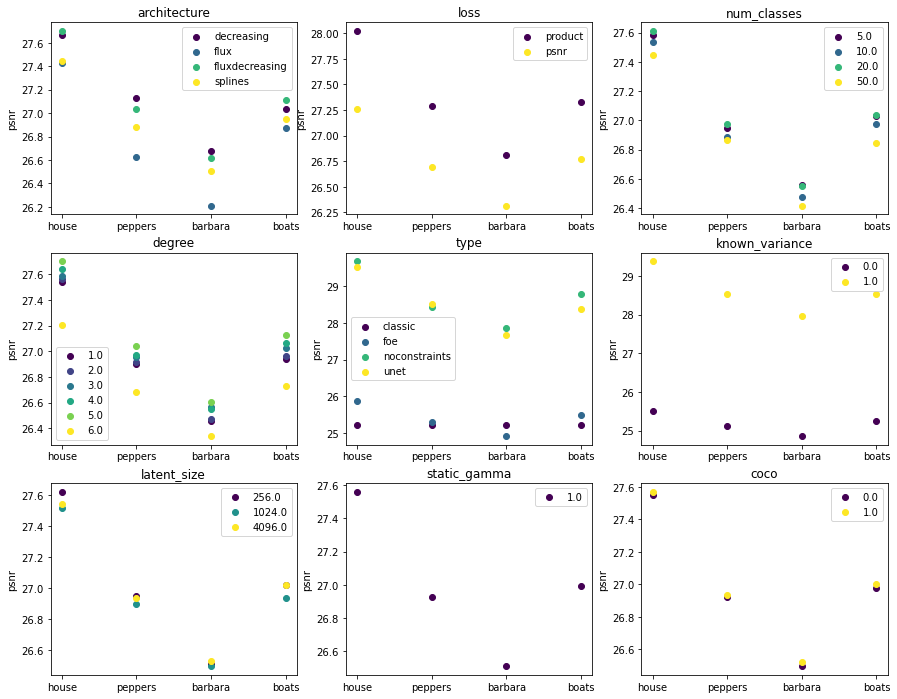

In [5]:
keys = ['architecture','loss','num_classes','degree','type','known_variance','latent_size','static_gamma','coco']
fig,axs = plt.subplots(ncols=3,nrows=3,figsize=(15,12))

for k,key in enumerate(keys):
    X = df.groupby(key).mean().reset_index()[[key]+imgs].values.T
    x,y = X[0],X[1:].T
    colors = cm.viridis(np.linspace(0,1,len(y)))
    for i in range(len(y)):
        axs[k//3,k%3].scatter(imgs,y[i],color=colors[i],label=x[i])
    axs[k//3,k%3].legend()
    axs[k//3,k%3].set_title(key)
    axs[k//3,k%3].set_ylabel('psnr')
    
plt.tight_layout

plt.show()

In [6]:
psnr_lit = np.array([[ 47.86, 47.69, 48.32, 47.81],
[ 42.92, 42.28, 44.01, 42.96],
[ 37.19, 36.27, 38.23, 37.63],
[ 32.83, 33.05, 35.06, 34.28],
[ 30.22, 31.22, 33.48, 32.03],
[ 28.32, 29.85, 32.17, 30.58],
[ 27.04, 28.72, 31.11, 29.20],
[ 23.15, 24.53, 26.74, 24.52],
[ 21.36, 22.48, 24.13, 21.68],
[ 19.77, 20.80, 21.66, 19.60]])

barbara,boats,house,peppers = psnr_lit.T

psnr_lit = np.array([house,peppers,barbara,boats])

variances = np.unique(df.variance.values)
vsFoe = []

for i in df[['variance','house','peppers','barbara','boats']].values:
    a = np.where(i[0]==variances)[0][0]
    vsFoe.append(i[1:]-psnr_lit.T[a])

    
vsFoe = np.array(vsFoe)

df['foe_house'] = vsFoe.T[0]
df['foe_peppers'] = vsFoe.T[1]
df['foe_barbara'] = vsFoe.T[2]
df['foe_boats'] = vsFoe.T[3]

flux psnr 5 2 unet 1 4096 1 1
fluxdecreasing product 10 2 unet 1 1024 1 1
splines psnr 50 1 unet 0 256 1 1
flux psnr 10 4 unet 1 4096 1 0


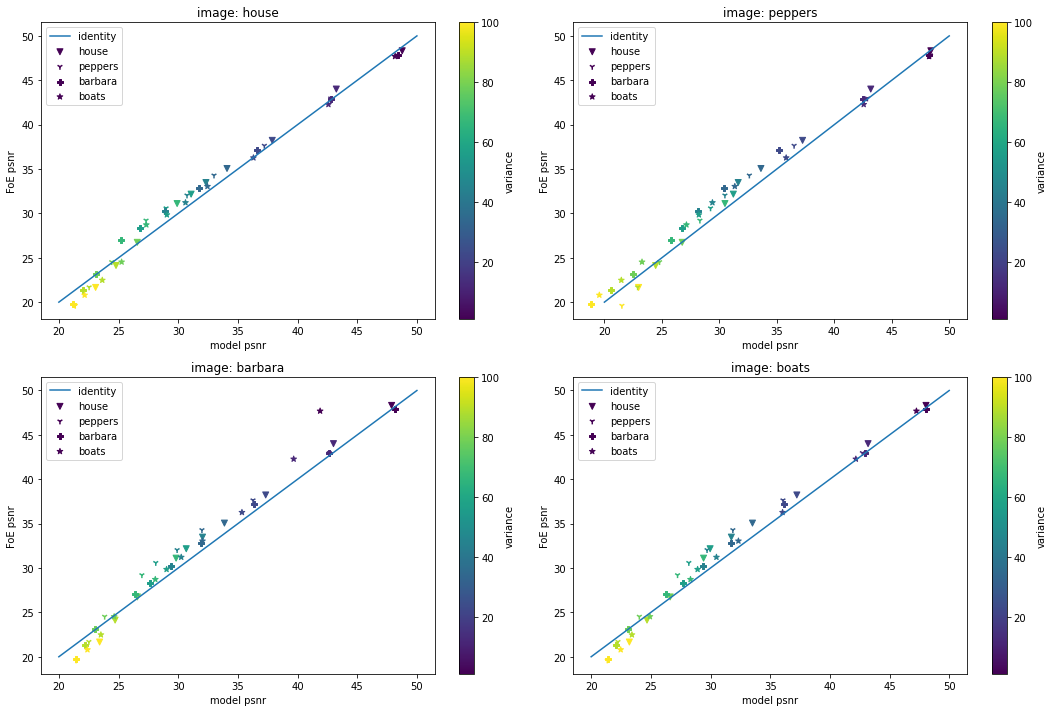

In [36]:
dg = df.groupby(keys).min().reset_index()
#vals = dg[imgs].values.T
vals = dg[['foe_house','foe_peppers','foe_barbara','foe_boats']].values.T

markers = ['v','1','P','*']

V = []

colors = cm.viridis(np.linspace(0,1,len(variances)))
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(15,10))
norm = mpl.colors.Normalize(vmin=np.amin(variances),vmax=np.amax(variances))
mappable = cm.ScalarMappable(norm)

for u,v in enumerate(np.argmax(vals,axis=1)):

    arch,loss,num_classes,degree,typee,known_variance,latent_size,static_gamma,coco = dg.iloc[v].values[:len(keys)]
    #arch,loss,num_classes,degree,typee,known_variance,latent_size = dg.iloc[v].values[:7]

    print(arch,loss,num_classes,degree,typee,known_variance,latent_size,static_gamma,coco)
    dh = df[(df.architecture==arch)&(df.loss==loss)&(df.num_classes==num_classes)&(df.degree==degree)&(df.type==typee)&(df.known_variance==known_variance)&(df.latent_size==latent_size)&(df.static_gamma==static_gamma)&(df.coco==coco)]
    #dh = df[(df.architecture==arch)&(df.loss==loss)&(df.num_classes==num_classes)&(df.degree==degree)&(df.type==typee)&(df.known_variance==known_variance)&(df.latent_size==latent_size)]
    psnr_model = dh[imgs].values.T
    model_var = dh.variance.values
    
    for i in range(len(imgs)):
        vec = [psnr_lit[i][j] for j in range(len(psnr_lit[i])) if variances[j] in model_var]
        c = [colors[j] for j in range(len(psnr_lit[i])) if variances[j] in model_var]
        
        im =  axs[u//2,u%2].scatter(psnr_model[i],vec,color=c,label=imgs[i],marker=markers[i])
        

    axs[u//2,u%2].plot([20,50],[20,50],label='identity')
    axs[u//2,u%2].legend()
    axs[u//2,u%2].set_xlabel('model psnr')
    axs[u//2,u%2].set_ylabel('FoE psnr')
    axs[u//2,u%2].set_title(f'image: {imgs[u]}')
    plt.colorbar(mappable=mappable,ax=axs[u//2,u%2],label='variance')
    
    weights = f"/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/{arch}/checkpoints/{arch}_{loss}_{num_classes}_{degree}_{latent_size}_{typee}_{int(known_variance)}_{int(static_gamma)}_{int(coco)}_0"
    weights = glob(f'{weights}*')
    for w in weights:
        os.system(f'cp {w} ../{arch}/checkpoints/')
    
plt.tight_layout()
plt.show()

In [49]:
glob(f'../*')

['../decreasing', '../flux', '../splines', '../general', '../fluxdecreasing']

In [46]:
glob(f'../{arch}/checkpoints/*')

['../flux/checkpoints/flux_psnr_5_2_4096_unet_1_1_1_0.data-00000-of-00001',
 '../flux/checkpoints/flux_psnr_5_2_4096_unet_1_1_1_0.index',
 '../flux/checkpoints/flux_psnr_10_4_4096_unet_1_1_0_0.data-00000-of-00001',
 '../flux/checkpoints/flux_psnr_10_4_4096_unet_1_1_0_0.index']

In [10]:
keys = ['architecture','loss','num_classes','degree','type','known_variance','latent_size','static_gamma','coco']
taken = []

while len(taken) < len(keys):
    std = []
    for key in np.setdiff1d(keys,taken):
        key1 = np.concatenate(([key],taken))
        dg = df.groupby(list(np.concatenate([key1,['variance']]))).std().reset_index()
        std.append(np.std(np.mean(dg.groupby(key).mean().reset_index()[imgs].values,axis=1)))
    taken.append(np.setdiff1d(keys,taken)[np.argmax(std)])
    
taken

['type',
 'known_variance',
 'loss',
 'architecture',
 'latent_size',
 'coco',
 'degree',
 'num_classes',
 'static_gamma']

In [12]:
it_lim = 10
factor = 1
model_256 = get_model(arch,it_lim=it_lim,image_size=image_size,num_classes = num_classes,
                                                                  second=True,degree1=degree,factor=factor,typee=typee,
                                                                 known_variance = known_variance,latent_size=latent_size,
                                                                 static_gamma=static_gamma)

model_256.load_weights(f"/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/{arch}/checkpoints/{arch}_{loss}_{num_classes}_{degree}_{latent_size}_{typee}_{int(known_variance)}_{int(static_gamma)}_{int(coco)}_0")

model_512 = get_model(arch,it_lim=it_lim,image_size=(512,512),num_classes = num_classes,
                                                                  second=True,degree1=degree,factor=factor,typee=typee,
                                                                 known_variance = known_variance,latent_size=latent_size,
                                                                 static_gamma=static_gamma)

model_512.load_weights(f"/home/joel/nmr-storage/fly_group_behavior/scripts/PeronaMalik/7_apr/{arch}/checkpoints/{arch}_{loss}_{num_classes}_{degree}_{latent_size}_{typee}_{int(known_variance)}_{int(static_gamma)}_{int(coco)}_0")


In [13]:
variance = [1,2,5,10,15,20,25,50,75,100]
set12_256 = ['../../images/Set12/02.png','../../images/Set12/03.png']
set12_512 = ['../../images/Set12/09.png','../../images/Set12/10.png']


set12_256 = np.array([[open_frame(im,var=v,CROP=256) for v in variance] for im in set12_256])
ys_256,noisy_256 = set12_256[:,:,0],set12_256[:,:,1]
ys_256,noisy_256 = np.concatenate(ys_256),np.concatenate(noisy_256)
ys_256,noisy_256 = np.expand_dims(ys_256,axis=-1),np.expand_dims(noisy_256,axis=-1)

set12_512 = np.array([[open_frame(im,var=v,CROP=512) for v in variance] for im in set12_512])
ys_512,noisy_512 = set12_512[:,:,0],set12_512[:,:,1]
ys_512,noisy_512 = np.concatenate(ys_512),np.concatenate(noisy_512)
ys_512,noisy_512 = np.expand_dims(ys_512,axis=-1),np.expand_dims(noisy_512,axis=-1)


In [14]:
varss = np.expand_dims(np.concatenate([variance,variance]),axis=-1)
varss = np.asarray(varss,dtype='float')

p_256 = model_256([noisy_256,varss])
p_512 = model_512([noisy_512,varss])

psnr_256 = tf.image.psnr(ys_256,p_256,255).numpy()
psnr_512 = tf.image.psnr(ys_512,p_512,255).numpy()

2023-06-19 15:19:55.173036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-06-19 15:19:56.094810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


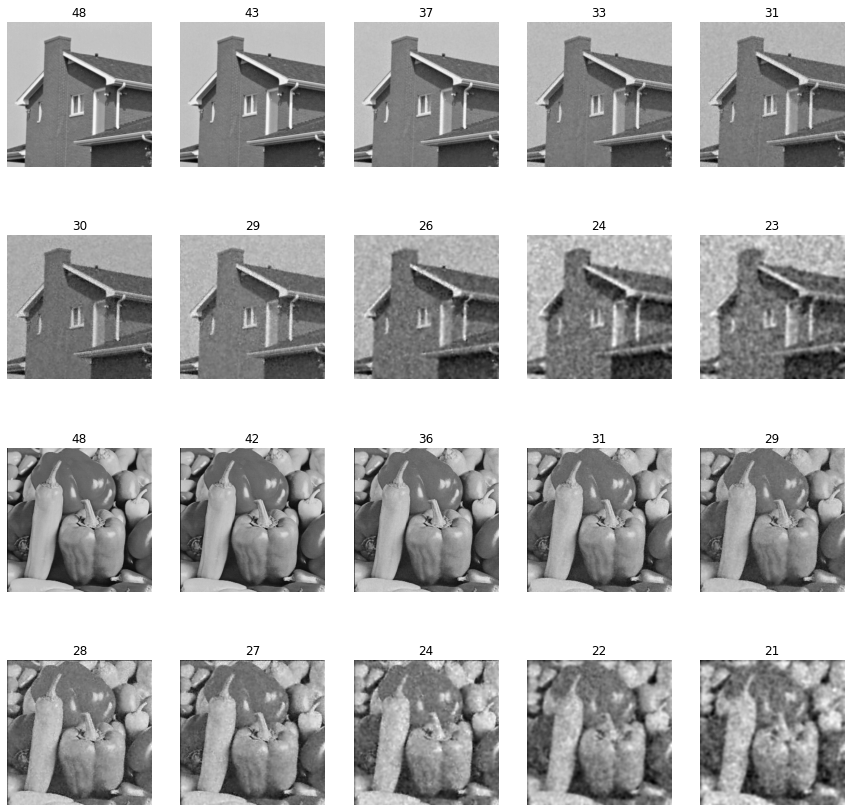

In [16]:
fig,axs = plt.subplots(nrows=4,ncols=5,figsize=(15,15))

for i in range(20):
    axs[i//5,i%5].imshow(p_256[i],cmap='gray')
    axs[i//5,i%5].axis('off')
    axs[i//5,i%5].set_title(int(psnr_256[i]))

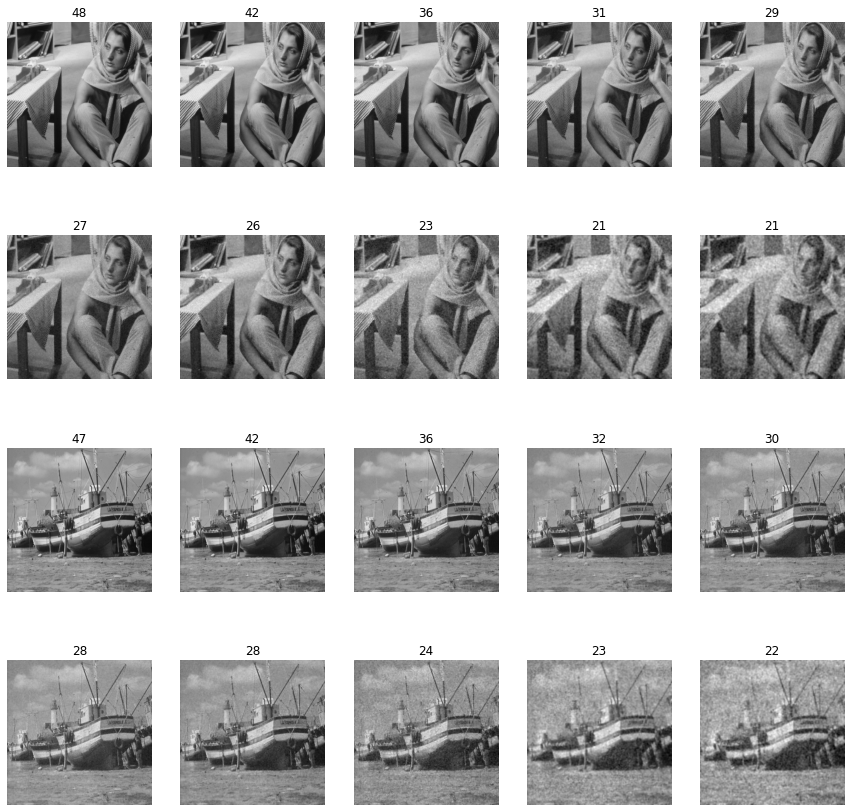

In [17]:
fig,axs = plt.subplots(nrows=4,ncols=5,figsize=(15,15))

for i in range(20):
    axs[i//5,i%5].imshow(p_512[i],cmap='gray')
    axs[i//5,i%5].axis('off')
    axs[i//5,i%5].set_title(int(psnr_512[i]))

In [23]:
model = tf.keras.models.Model(model_512.inputs,model_512.get_layer('embedded').output)
q = model([noisy_512,varss]).numpy()
q = q.reshape((20,int(np.sqrt(q.shape[1])),int(np.sqrt(q.shape[1]))))

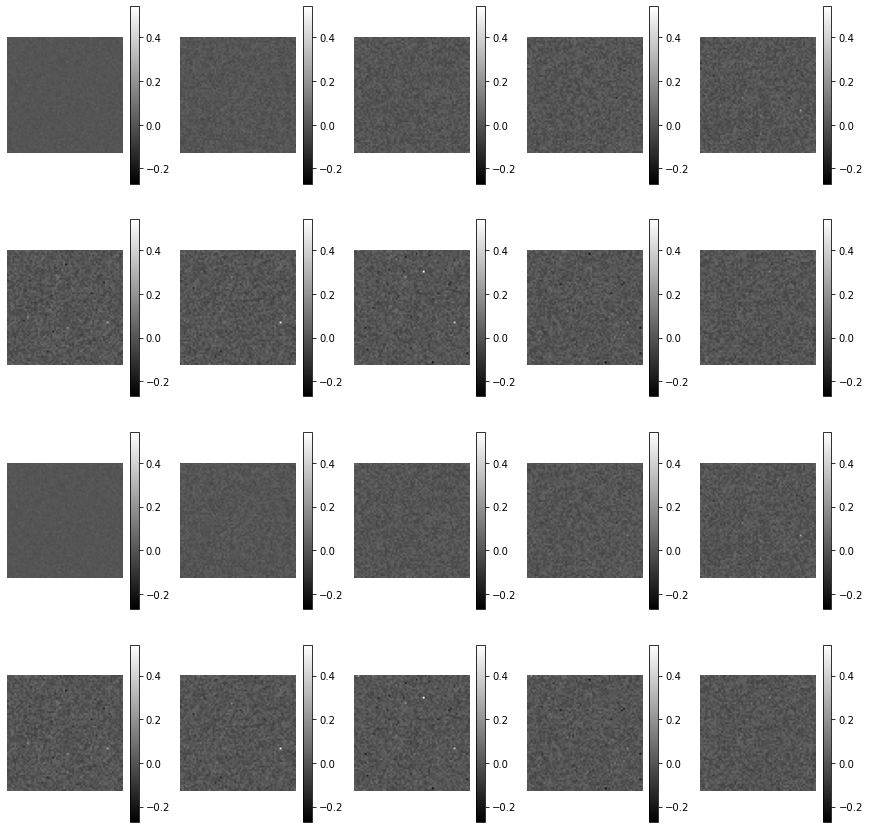

In [27]:
fig,axs = plt.subplots(nrows=4,ncols=5,figsize=(15,15))

for i in range(20):
    im = axs[i//5,i%5].imshow(q[i],cmap='gray',vmin=np.amin(q),vmax=np.amax(q))
    axs[i//5,i%5].axis('off')
    plt.colorbar(im,ax=[axs[i//5,i%5]])

In [31]:
model = model_256.get_layer('differential_operator')
q = model(noisy_256).numpy()

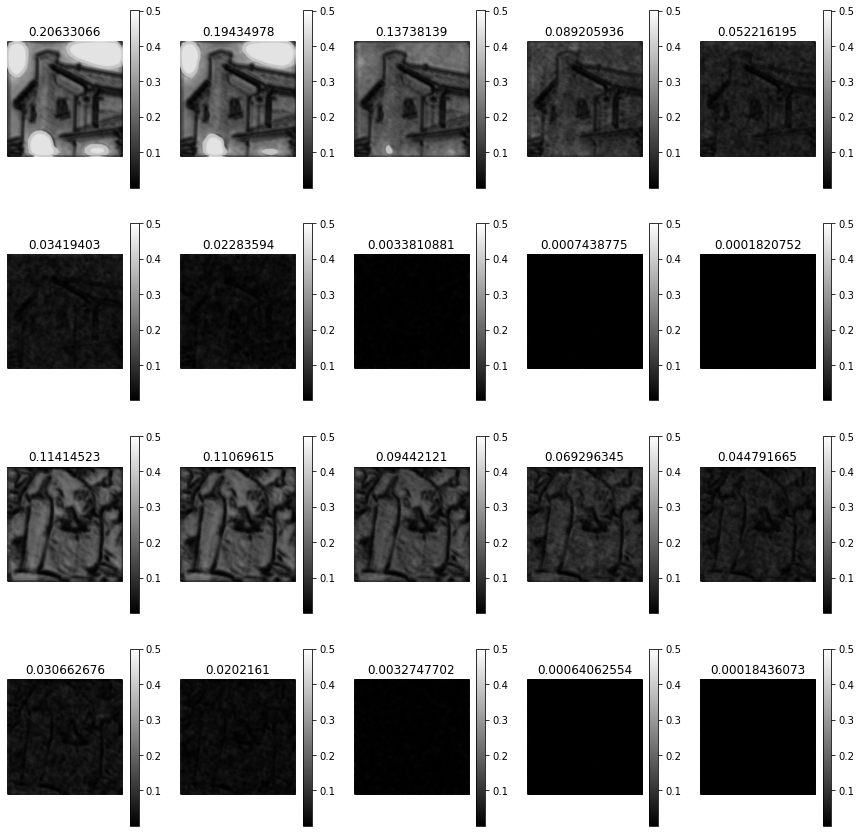

In [32]:
fig,axs = plt.subplots(nrows=4,ncols=5,figsize=(15,15))

for i in range(20):
    im = axs[i//5,i%5].imshow(q[i],cmap='gray',vmin=np.amin(q),vmax=np.amax(q))
    axs[i//5,i%5].axis('off')
    plt.colorbar(im,ax=[axs[i//5,i%5]])
    axs[i//5,i%5].set_title(np.mean(q[i]))

In [16]:
"""
Creating the model
"""
def conv_block(x, n_filt, size_conv=(5,5), n_conv=3):
    """
    Applies n_conv convolutions to the input with specified size and number of filters.
    """
    for c in range(n_conv):
        x = tf.keras.layers.Conv2D(n_filt, size_conv, padding="same", activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

def u_encoder(x, n_filt):
    """
    Applies conv_block and returnes max pooled and skip-connection.
    """
    x = conv_block(x, n_filt)
    return tf.keras.layers.MaxPool2D()(x), x

def u_decoder(pooled, skipped, n_filt):
    """
    Upsamples pooled and concats with skiped.
    """
    upsampled = tf.keras.layers.Convolution2DTranspose(n_filt, (2,2), strides=(2,2), padding='same')(pooled)
    return conv_block(tf.keras.layers.concatenate([upsampled, skipped]), n_filt)
    
    
def make_unet(inp, depth=3, output_channels=1):
    skipped = []
    p = inp
    for _ in range(depth):
        p, s = u_encoder(p, 2**(1+_))
        #p, s = u_encoder(p, 2*(1+_))
        skipped.append(s)
    p = conv_block(p, 2**(2+depth))
    for _ in reversed(range(depth)):
        p = u_decoder(p, skipped[_], 2**(2+_))  
        #p = u_decoder(p, skipped[_], (2**3)*(1+_))  
    p = tf.keras.layers.Conv2D(output_channels, (1,1), activation='sigmoid')(p)
    return p


In [18]:
inp = tf.keras.Input(image_size + (1,))
outp = make_unet(inp)
tf.keras.models.Model(inp, outp).summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 256, 256, 2)  52          ['input_2[0][0]']                
                                                                                                  
 batch_normalization_43 (BatchN  (None, 256, 256, 2)  8          ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                            

 activation_52 (Activation)     (None, 32, 32, 32)   0           ['batch_normalization_52[0][0]'] 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 32, 32, 32)   25632       ['activation_52[0][0]']          
                                                                                                  
 batch_normalization_53 (BatchN  (None, 32, 32, 32)  128         ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_53 (Activation)     (None, 32, 32, 32)   0           ['batch_normalization_53[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 32, 32, 32)   25632       ['activation_53[0][0]']          
          

 conv2d_53 (Conv2D)             (None, 256, 256, 4)  404         ['activation_61[0][0]']          
                                                                                                  
 batch_normalization_62 (BatchN  (None, 256, 256, 4)  16         ['conv2d_53[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_62 (Activation)     (None, 256, 256, 4)  0           ['batch_normalization_62[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 256, 256, 4)  404         ['activation_62[0][0]']          
                                                                                                  
 batch_normalization_63 (BatchN  (None, 256, 256, 4)  16         ['conv2d_54[0][0]']              
 ormalizat

In [15]:
model = get_model(arch,it_lim=it_lim,image_size=image_size,num_classes = num_classes,
                          second=True,degree1=degree,factor=factor,typee='unet',
                         known_variance = known_variance,latent_size=latent_size,
                         static_gamma=static_gamma)

In [16]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_270 (Lambda)            (None, 256, 256, 1)  0           ['input[0][0]']                  
                                                                                                  
 conv2d_62 (Conv2D)             (None, 128, 128, 32  320         ['lambda_270[0][0]']             
                                )                                                                 
                                                                                            

                                                                                                  
 activation_82 (Activation)     (None, 32, 32, 64)   0           ['batch_normalization_81[0][0]'] 
                                                                                                  
 separable_conv2d_32 (Separable  (None, 32, 32, 64)  4736        ['activation_82[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_82 (BatchN  (None, 32, 32, 64)  256         ['separable_conv2d_32[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 16, 16, 64)  0           ['batch_normalization_82[0][0]'] 
 )        

 da)                                                                                              
                                                                                                  
 lambda_273 (Lambda)            (None, 10, 1)        0           ['reshape_6[0][0]']              
                                                                                                  
 tf.compat.v1.shape_6 (TFOpLamb  (3,)                0           ['reshape_6[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_195 (Multiply)        (None, 10, 1)        0           ['lambda_281[0][0]',             
                                                                  'lambda_280[0][0]']             
                                                                                                  
 tf.__oper

                                                                                                  
 lambda_279 (Lambda)            (None, 1)            0           ['dense_14[0][0]']               
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None, 10, 1)       0           ['tf.math.cumsum_7[0][0]']       
 )                                                                                                
                                                                                                  
 tf.ones_like_74 (TFOpLambda)   (None, 10, 1)        0           ['reshape_7[0][0]']              
                                                                                                  
 lambda_276 (Lambda)            (None, None)         0           ['concatenate_108[0][0]']        
                                                                                                  
 tf.math.t

 lambda_287 (Lambda)            (None, 1)            0           ['multiply_201[0][0]']           
                                                                                                  
 add_106 (Add)                  (None, None, 1)      0           ['tf.expand_dims_96[0][0]',      
                                                                  'multiply_194[0][0]']           
                                                                                                  
 add_111 (Add)                  (None, None, 1)      0           ['tf.expand_dims_97[0][0]',      
                                                                  'lambda_287[0][0]']             
                                                                                                  
 concatenate_110 (Concatenate)  (None, 20, 1)        0           ['reshape_6[0][0]',              
                                                                  'reshape_7[0][0]']              
          

 multiply_205 (Multiply)        (None, 256, 256, 1)  0           ['tf.expand_dims_98[0][0]',      
                                                                  'lambda_293[0][0]']             
                                                                                                  
 tf.__operators__.getitem_68 (S  (None, 256, 1)      0           ['tf.zeros_like_60[0][0]']       
 licingOpLambda)                                                                                  
                                                                                                  
 concatenate_113 (Concatenate)  (None, 257, 256, 1)  0           ['tf.expand_dims_100[0][0]',     
                                                                  'multiply_205[0][0]']           
                                                                                                  
 tf.expand_dims_99 (TFOpLambda)  (None, 256, 1, 1)   0           ['tf.__operators__.getitem_68[0][
          

 tf.expand_dims_103 (TFOpLambda  (None, 1, 256, 1)   0           ['tf.__operators__.getitem_71[0][
 )                                                               0]']                             
                                                                                                  
 multiply_210 (Multiply)        (None, 256, 256, 1)  0           ['tf.expand_dims_101[0][0]',     
                                                                  'lambda_300[0][0]']             
                                                                                                  
 tf.__operators__.getitem_70 (S  (None, 256, 1)      0           ['tf.zeros_like_62[0][0]']       
 licingOpLambda)                                                                                  
                                                                                                  
 concatenate_116 (Concatenate)  (None, 257, 256, 1)  0           ['tf.expand_dims_103[0][0]',     
          

                                                                                                  
 tf.zeros_like_64 (TFOpLambda)  (None, 256, 256, 1)  0           ['add_115[0][0]']                
                                                                                                  
 tf.expand_dims_106 (TFOpLambda  (None, 1, 256, 1)   0           ['tf.__operators__.getitem_73[0][
 )                                                               0]']                             
                                                                                                  
 multiply_215 (Multiply)        (None, 256, 256, 1)  0           ['tf.expand_dims_104[0][0]',     
                                                                  'lambda_307[0][0]']             
                                                                                                  
 tf.__operators__.getitem_72 (S  (None, 256, 1)      0           ['tf.zeros_like_64[0][0]']       
 licingOpL

                                ),                                                                
                                 (None, 256, 256, 1                                               
                                ))                                                                
                                                                                                  
 tf.zeros_like_66 (TFOpLambda)  (None, 256, 256, 1)  0           ['add_117[0][0]']                
                                                                                                  
 tf.expand_dims_109 (TFOpLambda  (None, 1, 256, 1)   0           ['tf.__operators__.getitem_75[0][
 )                                                               0]']                             
                                                                                                  
 multiply_220 (Multiply)        (None, 256, 256, 1)  0           ['tf.expand_dims_107[0][0]',     
          

 )                                                                                                
                                                                                                  
 lambda_321 (Lambda)            ((None, 256, 256, 1  0           ['add_119[0][0]']                
                                ),                                                                
                                 (None, 256, 256, 1                                               
                                ))                                                                
                                                                                                  
 tf.zeros_like_68 (TFOpLambda)  (None, 256, 256, 1)  0           ['add_119[0][0]']                
                                                                                                  
 tf.expand_dims_112 (TFOpLambda  (None, 1, 256, 1)   0           ['tf.__operators__.getitem_77[0][
 )        

 licingOpLambda)                                                                                  
                                                                                                  
 tf.expand_dims_113 (TFOpLambda  (None, 256, 256, 1)  0          ['g_5[0][0]']                    
 )                                                                                                
                                                                                                  
 lambda_328 (Lambda)            ((None, 256, 256, 1  0           ['add_121[0][0]']                
                                ),                                                                
                                 (None, 256, 256, 1                                               
                                ))                                                                
                                                                                                  
 tf.zeros_

 g_6 (Lambda)                   (None, 256, 256)     0           ['multiply_233[0][0]']           
                                                                                                  
 tf.__operators__.getitem_81 (S  (None, 256, 1)      0           ['tf.zeros_like_73[0][0]']       
 licingOpLambda)                                                                                  
                                                                                                  
 tf.expand_dims_116 (TFOpLambda  (None, 256, 256, 1)  0          ['g_6[0][0]']                    
 )                                                                                                
                                                                                                  
 lambda_335 (Lambda)            ((None, 256, 256, 1  0           ['add_123[0][0]']                
                                ),                                                                
          

                                                                                                  
 tf.zeros_like_75 (TFOpLambda)  (None, 256, 256, 1)  0           ['input[0][0]']                  
                                                                                                  
 g_7 (Lambda)                   (None, 256, 256)     0           ['multiply_238[0][0]']           
                                                                                                  
 tf.__operators__.getitem_83 (S  (None, 256, 1)      0           ['tf.zeros_like_75[0][0]']       
 licingOpLambda)                                                                                  
                                                                                                  
 tf.expand_dims_119 (TFOpLambda  (None, 256, 256, 1)  0          ['g_7[0][0]']                    
 )                                                                                                
          

                                                                                                  
 multiply_243 (Multiply)        (None, 256, 256, 20  0           ['lambda_348[0][0]',             
                                )                                 'tf.cast_38[0][0]']             
                                                                                                  
 tf.zeros_like_77 (TFOpLambda)  (None, 256, 256, 1)  0           ['input[0][0]']                  
                                                                                                  
 g_8 (Lambda)                   (None, 256, 256)     0           ['multiply_243[0][0]']           
                                                                                                  
 tf.__operators__.getitem_85 (S  (None, 256, 1)      0           ['tf.zeros_like_77[0][0]']       
 licingOpLambda)                                                                                  
          

                                                                                                  
 tf.cast_39 (TFOpLambda)        (None, 256, 256, 20  0           ['tf.math.logical_and_39[0][0]'] 
                                )                                                                 
                                                                                                  
 multiply_248 (Multiply)        (None, 256, 256, 20  0           ['lambda_355[0][0]',             
                                )                                 'tf.cast_39[0][0]']             
                                                                                                  
 tf.zeros_like_79 (TFOpLambda)  (None, 256, 256, 1)  0           ['input[0][0]']                  
                                                                                                  
 g_9 (Lambda)                   (None, 256, 256)     0           ['multiply_248[0][0]']           
          